In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Fetch stock data (Apple stock)
stock_data = yf.Ticker("AAPL").history(period="max")
stock_data = stock_data.loc["2000-01-01":].copy()


In [3]:
# Add features
stock_data['Return'] = stock_data['Close'].pct_change()
stock_data['Moving_Avg_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['Moving_Avg_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['Volatility'] = stock_data['Close'].rolling(window=5).std()
stock_data['Target'] = stock_data['Close'].shift(-1)  # Predict the next day's close price


In [4]:
# Fetch S&P 500 data
sp500 = yf.Ticker("^GSPC").history(period="max")
sp500 = sp500.loc["2000-01-01":].copy()
sp500['SP500_Return'] = sp500['Close'].pct_change()


In [5]:
# Fetch Technology ETF data
tech_etf = yf.Ticker("XLK").history(period="max")
tech_etf = tech_etf.loc["2000-01-01":].copy()
tech_etf['Tech_Return'] = tech_etf['Close'].pct_change()


In [6]:
# Use a library like yfinance to fetch data for major indices, such as:
## S&P 500 (^GSPC)
## Nasdaq Composite (^IXIC)
## Dow Jones Industrial Average (^DJI)

# Use ETFs (Exchange Traded Funds) representing specific sectors. Examples include:
## Technology: XLK
## Healthcare: XLV
## Financials: XLF

# Merge external data
sp500 = sp500[['SP500_Return']].reset_index()
tech_etf = tech_etf[['Tech_Return']].reset_index()
stock_data = stock_data.reset_index()
stock_data = pd.merge(stock_data, sp500, on='Date', how='left')
stock_data = pd.merge(stock_data, tech_etf, on='Date', how='left')


In [7]:
### Fetch and process data for relevant ETFs as with the S&P 500.

# Add relative strength and rolling averages
stock_data['Relative_SP500'] = stock_data['Return'] - stock_data['SP500_Return']
stock_data['Relative_Tech'] = stock_data['Return'] - stock_data['Tech_Return']
stock_data['SP500_MA_5'] = stock_data['SP500_Return'].rolling(window=5).mean()
stock_data['Tech_MA_5'] = stock_data['Tech_Return'].rolling(window=5).mean()


In [8]:
# Drop rows with NaN values introduced by rolling operations
stock_data = stock_data.dropna()

In [9]:
# Features and target
features = ['Close', 'Return', 'Moving_Avg_5', 'Moving_Avg_20', 'Volatility',
            'SP500_Return', 'Tech_Return', 'Relative_SP500', 'Relative_Tech', 
            'SP500_MA_5', 'Tech_MA_5']
target = 'Target'

X = stock_data[features].values
y = stock_data[target].values

# # Scale data for LSTM
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Scale data for LSTM using separate scalers for X and y
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))


In [10]:
# Create sequences for LSTM (e.g., 5-day lookback)
time_steps = 5
X_seq, y_seq = [], []

for i in range(time_steps, len(X_scaled)):
    X_seq.append(X_scaled[i-time_steps:i])
    y_seq.append(y_scaled[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


In [11]:
# Build LSTM model with additional layers and hyperparameter tuning
model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # Increased units to 128
model.add(Dropout(0.2))
# model.add(LSTM(units=50, return_sequences=False))
model.add(LSTM(units=128, return_sequences=True))  # Added another LSTM layer
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))  # Added a final LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting a single value

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')  # Adam optimizer is retained

# Add early stopping to halt training when validation loss plateaus
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
# history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/50


/opt/miniconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0126 - val_loss: 5.5609e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6775e-04 - val_loss: 1.5258e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.7466e-04 - val_loss: 1.9590e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9630e-04 - val_loss: 4.2296e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.4210e-04 - val_loss: 3.9635e-04
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3167e-04 - val_loss: 2.0736e-04
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.6232e-04 - val_loss: 2.4608e-04


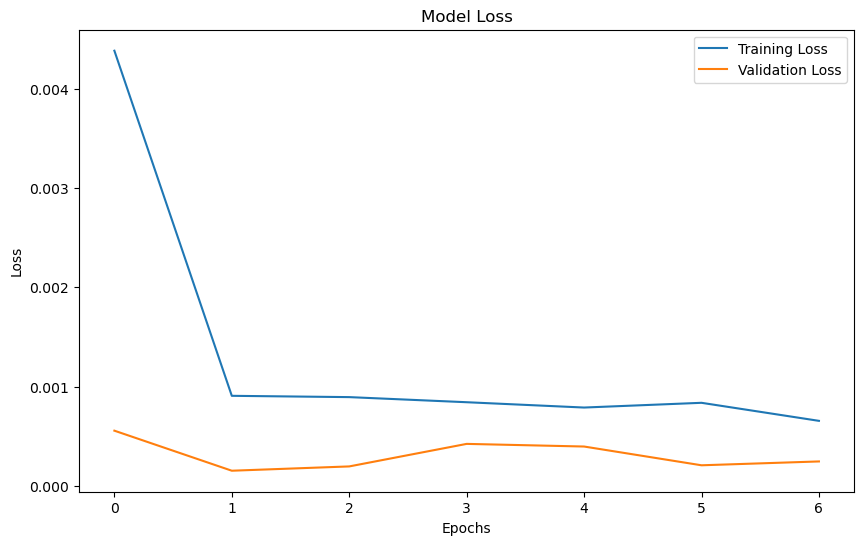

In [12]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


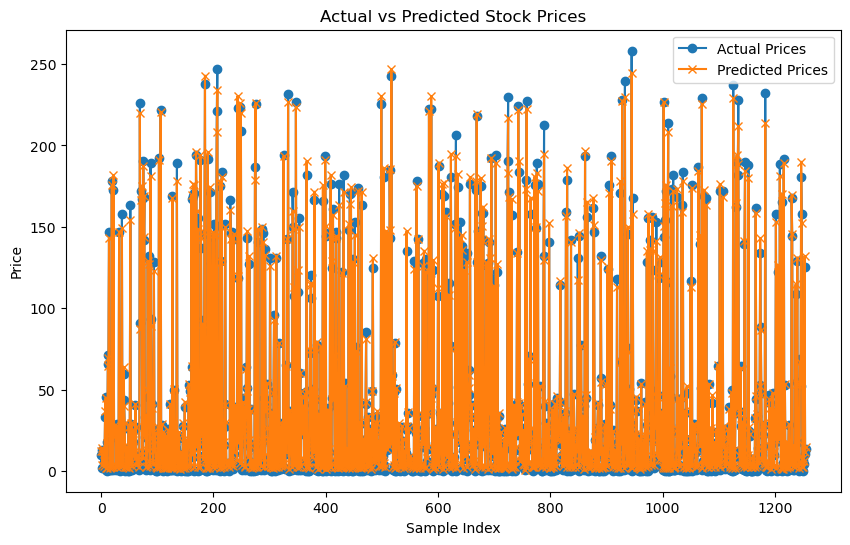

In [13]:
# Predict on test data
y_pred = model.predict(X_test)

# Rescale predictions back to original scale
# y_test_rescaled = scaler.inverse_transform(y_test)
# y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual Prices", marker='o')
plt.plot(y_pred_rescaled, label="Predicted Prices", marker='x')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.show()


In [14]:

# # Rescale predictions and actual values to original scale
# y_test_rescaled = scaler.inverse_transform(y_test)
# y_pred_rescaled = scaler.inverse_transform(y_pred)

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print results
print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Evaluation Metrics:
Mean Squared Error (MSE): 10.221178970986001
Root Mean Squared Error (RMSE): 3.1970578616887746
Mean Absolute Error (MAE): 2.294139607044257
R² Score: 0.9973171162381614


Accuracy (within 2.0% tolerance): 15.68%


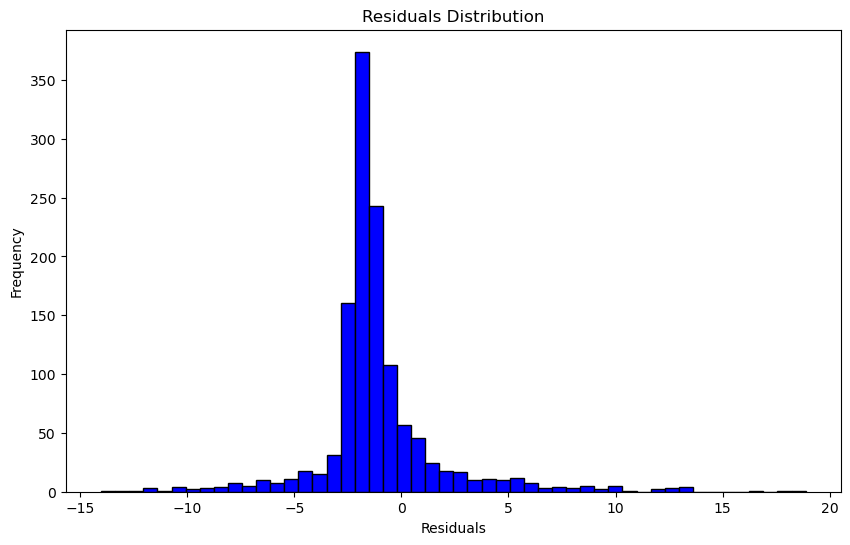

In [15]:
# Define a tolerance range (e.g., 2% of the actual value)
tolerance_percentage = 0.02

# Compute absolute percentage error
errors = np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)

# Calculate accuracy as the proportion of errors within the tolerance
accuracy = np.mean(errors <= tolerance_percentage)

# Print accuracy
print(f"Accuracy (within {tolerance_percentage * 100}% tolerance): {accuracy * 100:.2f}%")

# Plot residuals (actual - predicted)
residuals = y_test_rescaled - y_pred_rescaled
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='blue', edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0185 - val_loss: 3.6754e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.6290e-04 - val_loss: 2.6754e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.9981e-04 - val_loss: 2.9967e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.0102e-04 - val_loss: 5.3709e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.2017e-04 - val_loss: 2.8448e-04
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.7724e-04 - val_loss: 2.7512e-04
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.3467e-04 - val_loss: 2.4829e-04
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.0965e-04 - val_loss: 3.5003e-04
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.7805e-04 - val_loss: 4.2001e-04
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.7188e-04 - val_loss: 2.0319e-04
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Text(0.5, 1.0, 'Actual vs Predicted Stock Prices (Larger Lookback Window')

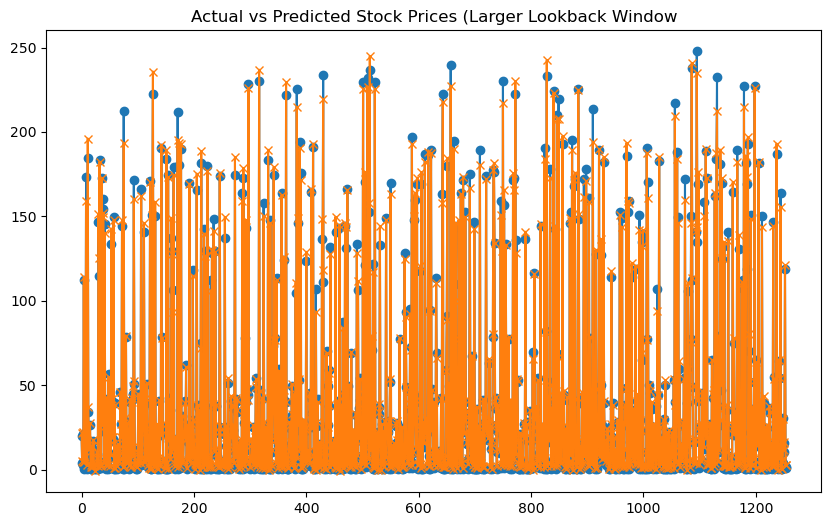

In [16]:
# Experiment with larger lookback windows
time_steps = 10  # Experimenting with a larger lookback window
X_seq_large, y_seq_large = [], []

for i in range(time_steps, len(X_scaled)):
    X_seq_large.append(X_scaled[i-time_steps:i])
    y_seq_large.append(y_scaled[i])

X_seq_large, y_seq_large = np.array(X_seq_large), np.array(y_seq_large)

# Train-test split with larger lookback window
X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(X_seq_large, y_seq_large, test_size=0.2, random_state=42)

# Retrain model with larger lookback window
history_large = model.fit(X_train_large, y_train_large, epochs=50, batch_size=32, validation_data=(X_test_large, y_test_large), callbacks=[early_stopping], verbose=1)

# Predict and evaluate with larger lookback window
y_pred_large = model.predict(X_test_large)
y_test_rescaled_large = scaler_y.inverse_transform(y_test_large)
y_pred_rescaled_large = scaler_y.inverse_transform(y_pred_large)

# Plot actual vs predicted prices for larger lookback window
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled_large, label="Actual Prices", marker='o')
plt.plot(y_pred_rescaled_large, label="Predicted Prices", marker='x')
plt.title("Actual vs Predicted Stock Prices (Larger Lookback Window")


In [17]:
# Predict direction (1 for up, 0 for down) based on Close price
y_test_direction = (y_test_rescaled[1:] > y_test_rescaled[:-1]).astype(int)
y_pred_direction = (y_pred_rescaled[1:] > y_pred_rescaled[:-1]).astype(int)

# Calculate classification accuracy
direction_accuracy = np.mean(y_test_direction == y_pred_direction)

print(f"Direction Prediction Accuracy: {direction_accuracy * 100:.2f}%")


Direction Prediction Accuracy: 97.61%


In [18]:
# Predict direction (1 for up, 0 for down) based on Close price
y_test_direction = (y_test_rescaled_large[1:] > y_test_rescaled_large[:-1]).astype(int)
y_pred_direction = (y_pred_rescaled_large[1:] > y_pred_rescaled_large[:-1]).astype(int)

# Calculate classification accuracy
direction_accuracy = np.mean(y_test_direction == y_pred_direction)

print(f"Direction Prediction Accuracy: {direction_accuracy * 100:.2f}%")

Direction Prediction Accuracy: 96.49%


In [23]:
# Save the model after training
model.save('lstm_model.keras')

In [24]:
# Later, load the model for continuous training
from tensorflow.keras.models import load_model
model = load_model('lstm_model.keras')

# # Later, load the model for continuous training
# from tensorflow.keras.models import load_model
# model = load_model('lstm_model.h5')

In [25]:
from datetime import datetime, date, timedelta


def evaluate_strategy(date, predictions, actual_prices):
    """
    Evaluates the trading strategy (Buy, Sell, Hold) for a given date based on the model's predictions.

    Args:
        date (str): The date to evaluate in 'YYYY-MM-DD' format.
        predictions (numpy.ndarray): Rescaled predicted prices from the LSTM model.
        actual_prices (numpy.ndarray): Rescaled actual prices from the dataset.
        dates (list or numpy.ndarray): List of dates corresponding to the predictions.

    Returns:
        str: Action to take for the given date (Buy, Sell, Hold).
    """
    try:
        # Convert dates array to datetime if not already
        array_length = len(y_pred_rescaled)
        
        # Get today's date
        end_date = datetime.today()

        # Calculate the start date based on the array length
        start_date = end_date - timedelta(days=array_length - 1)

        # Create a date range
        date_array = pd.date_range(start=start_date, end=end_date, periods=array_length).strftime("%Y-%m-%d").tolist()
        
        
        
        # Ensure date is in the correct format and extract only the date part
        target_date = datetime.strptime(date, '%Y-%m-%d').date()

        # Format the target date as "YYYY-MM-DD"
        formatted_date = target_date.strftime('%Y-%m-%d')
        
        # Check if the date exists and get its index
        if formatted_date in date_array:
            index = date_array.index(formatted_date)
            print(f"Date {formatted_date} found at index {index}.")
        else:
            print(f"Date {formatted_date} not found in the array.")

        # Get predicted prices for the given date and the next day
        predicted_price_today = predictions[index]
        predicted_price_tomorrow = (
            predictions[index + 1] if index + 1 < len(predictions) else None
        )

        if predicted_price_tomorrow is not None:
            if predicted_price_tomorrow > predicted_price_today:
                action = "Buy"
            elif predicted_price_tomorrow < predicted_price_today:
                action = "Sell"
            else:
                action = "Hold"

            return (
                f"Prediction for {date} (action for the next day):\n"
                f"Today's Predicted Price: {predicted_price_today[0]:.2f}\n"
                f"Tomorrow's Predicted Price: {predicted_price_tomorrow[0]:.2f}\n"
                f"Action: {action}"
            )
        else:
            return f"No prediction available for the next day after {date}."

    except Exception as e:
        return f"An error occurred: {str(e)}"


# Example usage
predictions = y_pred_rescaled
actual_prices = y_test_rescaled

date_to_evaluate = "2025-1-1"
result = evaluate_strategy(date_to_evaluate, predictions, actual_prices)
print(result)


Date 2025-01-01 found at index 1233.
Prediction for 2025-1-1 (action for the next day):
Today's Predicted Price: 15.75
Tomorrow's Predicted Price: 3.03
Action: Sell
